# SQL資料更新

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
DB_Host = "192.168.1.16"
DB_Name = "X01"
DB_User = "cm23357868"#以我的帳號為例，請填入您個人帳號
DB_Password = "86875332"#以我的密碼為例，請填入您個人密碼

print("Connecting to database using pyodbc...")

db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)

print("Succesfully Connected to database using pyodbc!")

cursor = db.cursor()
#假設我有個列表(tuple也可以)裡面有股票代號，示範只導入前十項

s_code_df = pd.read_excel("C:\\Users\\larryx30\\Desktop\\ALLSTOCK.xlsx")
stock_ls = list(s_code_df.loc[0:,'NUM'])
data_ls = []
data_frame = pd.DataFrame()
for stock_code in tqdm(stock_ls):
    query1 = """SELECT  [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[資使用率]
      ,[融資維持率(%%)]
      FROM [X01].[dbo].[日融資券排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query2 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[開盤價]
      ,[最高價]
      ,[最低價]
      ,[收盤價]
      ,[成交金額(千)]
      FROM [X01].[dbo].[日收盤表排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query3 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[還原收盤價]
      FROM [X01].[dbo].[日報酬率比較表] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    query4 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[投信買賣超金額(千)]
      ,[投信持股比率(%%)]
      ,[投信持股市值(百萬)]
      ,[投信持股成本]
      FROM [X01].[dbo].[日投信明細與排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    query5 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[外資買賣超金額(千)]
      ,[外資持股比率(%%)]
      ,[外資持股市值(百萬)]
      ,[外資持股成本]
      FROM [X01].[dbo].[日外資持股與排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    
    df_Financing = pd.read_sql(query1, db)#.dropna()
    df_price = pd.read_sql(query2, db)
    df_res_price = pd.read_sql(query3, db)
    df_sit = pd.read_sql(query4, db)
    df_ff = pd.read_sql(query5, db)
    df_from_sql = df_price.merge(df_Financing, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_res_price, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_sit,on = ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_ff,on = ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql['日期'] = pd.to_datetime(df_from_sql['日期'],format = "%Y%m%d").fillna(0)
    df_from_sql = df_from_sql.set_index('日期')
    data_ls.append(df_from_sql)
    data_frame = pd.concat([data_frame,df_from_sql],axis = 0)
    


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


100%|██████████| 1776/1776 [1:14:58<00:00,  2.53s/it]


# 整理樞紐1

In [2]:
feature_ls = data_frame.columns[3:]
data_frame = data_frame.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(feature_ls):
    data_pivot = data_frame.pivot('日期','股票代號',feature)
    data_pivots_ls.append(data_pivot)
data_dict = {str(stock_ls[i]):data_ls[i] for i in range(len(stock_ls))}
    

100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


# 整理樞紐2及字典合併

In [3]:
pivot_dict = {str(feature_ls[i]):data_pivots_ls[i] for i in range(len(feature_ls))}
data_dict.update(pivot_dict)

# 回測樣本代號

In [4]:
response1 = pd.read_excel(r"C:\Users\larryx30\Desktop\\ALLSTOCK.xlsx")
response1.index = response1.index+1
AS = response1['NUM']
response2 = pd.read_excel(r"C:\Users\larryx30\Desktop\\TCRINEW.xlsx")
response2.index = response2.index+1
SKTCRI = response2['NUM']
response3 = pd.read_excel(r"C:\Users\larryx30\Desktop\\STOCKFUTURE.xlsx")
response3.index = response3.index+1
SF = response3['NUM']
DDW = {}
for j in tqdm(AS):
    DDW[str(j)] = data_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last','成交金額(千)':'sum','資使用率':'last','融資維持率(%)':'last', '還原收盤價':'last','投信持股比率(%)':'last','投信持股成本':'last','外資持股比率(%)':'last','外資持股成本':'last','投信持股市值(百萬)':'last'})
for fi in tqdm(AS):
    DDW[str(fi)] = DDW[str(fi)].fillna(method = 'pad' ,axis = 0)

100%|██████████| 1776/1776 [00:00<00:00, 13149.75it/s]


In [5]:
DDW['2330'].tail(3)

,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,外資持股比率(%),外資持股成本,投信持股市值(百萬)
日期,,,,,,,,,,,,,
2022-09-09,485.0,491.5,472.0,475.0,53665551,0.42,157.117203,472.28,0.61,523.68,71.55,323.24,75244.30
2022-09-16,485.0,495.0,469.0,472.0,65945728,0.42,156.869293,472.00,0.61,520.48,71.53,321.32,75044.02
2022-09-23,472.0,473.0,466.5,467.0,9713676,0.42,155.350906,467.00,0.61,520.26,71.51,321.41,74441.93


# 計算大盤夏普

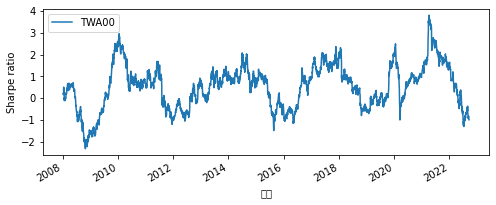

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
shar2 = pd.DataFrame()

change2 = data_dict["TWA00"]["還原收盤價"].pct_change()
sigma2 = change2.std()
data_dict["TWA00"]['rolling_ret'] = change2.rolling(252).mean()
data_dict["TWA00"]['rolling_std'] = change2.rolling(252).std()
data_dict["TWA00"]['sharpe'] = (data_dict["TWA00"]['rolling_ret'] / data_dict["TWA00"]['rolling_std']) * (252 ** 0.5)

APT2 = data_dict["TWA00"]["sharpe"]
APT2.name = 'TWA00'
DDW['TWA00']["sharpe"] = data_dict['TWA00']['sharpe'].groupby(pd.Grouper(freq='1W')).tail(1)
if len(shar2) == 0:
    shar2 = APT2
else:
    shar2 = pd.merge(shar2,APT2,left_on = shar2.index,right_on = APT2.index,how = 'outer')
    shar2.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
shar2.plot(label = "TWA00")
plt.legend()

# 計算全股票夏普

100%|██████████| 1776/1776 [00:39<00:00, 44.87it/s]


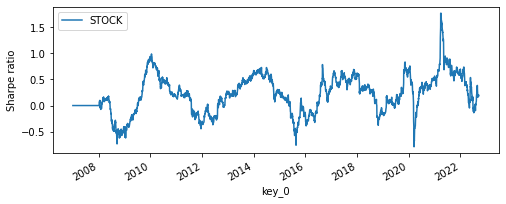

In [7]:
#Sharpe
shar = pd.DataFrame()

for i in tqdm(AS):
    change = data_dict[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    data_dict[str(i)]['rolling_ret'] = change.rolling(252).mean()
    data_dict[str(i)]['rolling_std'] = change.rolling(252).std()
    data_dict[str(i)]['sharpe'] = (data_dict[str(i)]['rolling_ret'] / data_dict[str(i)]['rolling_std']) * (252 ** 0.5)

    APT = data_dict[str(i)]["sharpe"]
    APT.name = i

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
wholesharpe = shar.sort_index().sum(axis = 1)/len(shar.columns)
wholesharpe.plot(label = "STOCK")
plt.legend()
plt.savefig("一籃子夏普")

# 母關鍵點策略

100%|██████████| 1100/1100 [02:22<00:00,  7.69it/s]


Text(0, 0.5, 'Profit')

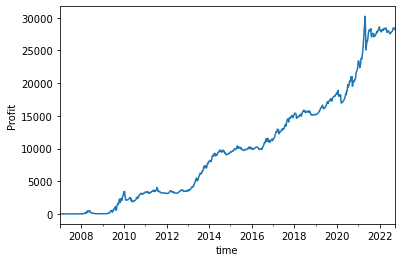

In [8]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['MAX52'] = DDW[str(x)]["還原收盤價"].rolling(52).max()
    DDW[str(x)]["MAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    KPBS = 0
    KPBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["還原收盤價"].iloc[z]  > DDW[str(x)]["MAX52S"].iloc[z] and  DDW[str(x)]["成交金額(千)"].iloc[z] > 50000 and  DDW[str(x)]["資使用率"].iloc[z] < 15 \
        and DDW[str(x)]["成交金額(千)"].shift(1).iloc[z] > 20000  :
        
            KPBS = 1

        elif DDW[str(x)]["4MA"].iloc[z] < DDW[str(x)]["4MAS"].iloc[z] and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].shift(1).iloc[z] :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    DDW[str(x)]["KPBUY"] = KPBUY
    DDW[str(x)]["KPBUYS"] = DDW[str(x)]["KPBUY"].shift(1)
    pzb = DDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = DDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    DDW[str(x)]["KPRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = DDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =trr.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理多單買賣訊01值

78.14738124238733
0.0
435.0


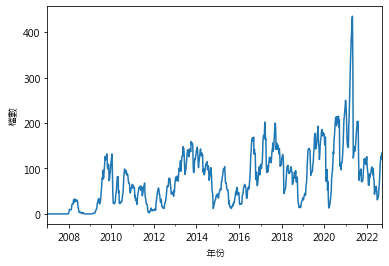

In [9]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('多方部位變化表.png')


# 填寫資料更新日期

In [58]:
當週日期 = '2022-09-23'
前週日期 = '2022-09-16'

# 關鍵點當週買進部位

In [59]:
關鍵點持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==1)]
關鍵點買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==1) & (pz2.loc[前週日期]==0)]
關鍵點賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==1)]
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出部位")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))


關鍵點買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
關鍵點買進檔數 0
關鍵點持有部位數目 120
關鍵點賣出部位
1444    0.0
1712    0.0
1720    0.0
1733    0.0
2065    0.0
3209    0.0
3531    0.0
4543    0.0
4557    0.0
4906    0.0
5278    0.0
6469    0.0
8234    0.0
8420    0.0
Name: 2022-09-23 00:00:00, dtype: float64
關鍵點賣出檔數 14


# 關鍵點歷年損益

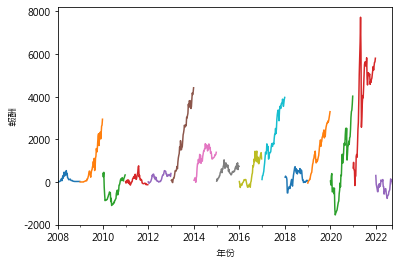

In [12]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrt = trr.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = trrt.plot()
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('主模型歷年損益.png')

In [110]:
trrt['2022']

key_0
2022-01-02    302.384768
2022-01-09   -105.774596
2022-01-16   -215.077551
2022-01-23   -320.759619
2022-01-30   -455.248782
2022-02-06   -455.248782
2022-02-13   -171.542258
2022-02-20   -101.212695
2022-02-27   -246.855060
2022-03-06    -85.775243
2022-03-13   -198.898302
2022-03-20    -94.446746
2022-03-27     94.227530
2022-04-03     57.657861
2022-04-10     32.538874
2022-04-17     29.416990
2022-04-24    112.207286
2022-05-01   -212.855214
2022-05-08   -220.618225
2022-05-15   -570.251754
2022-05-22   -440.575329
2022-05-29   -364.987594
2022-06-05   -313.838161
2022-06-12   -322.818176
2022-06-19   -549.088715
2022-06-26   -646.677398
2022-07-03   -769.768314
2022-07-10   -648.023874
2022-07-17   -628.844139
2022-07-24   -598.572740
2022-07-31   -450.588728
2022-08-07   -419.707973
2022-08-14   -358.597742
2022-08-21   -114.927123
2022-08-28    143.810043
2022-09-04     97.171628
2022-09-11     26.998713
2022-09-18    102.202293
2022-09-25    -85.534540
Freq: W-SUN, dtype:

<AxesSubplot:xlabel='key_0'>

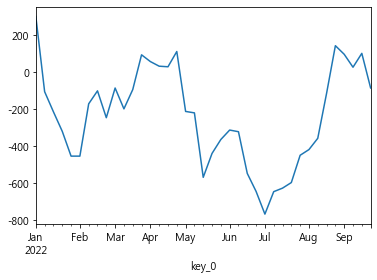

In [111]:
trrt['2022'].plot()

# 放空補丁策略

100%|██████████| 1100/1100 [03:05<00:00,  5.94it/s]


<AxesSubplot:xlabel='key_0'>

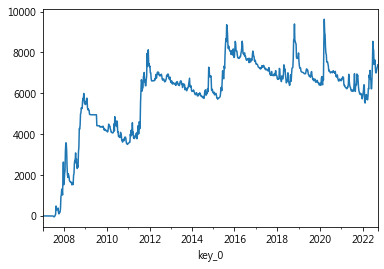

In [276]:
import talib
ERROR = []
trrs = pd.DataFrame()
pzs = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['LOW5'] = DDW[str(x)]["最低價"].rolling(2).min()
    DDW[str(x)]['SMAX3'] = DDW[str(x)]["最高價"].rolling(2).max()
    DDW[str(x)]["LOW5S"] = DDW[str(x)]["LOW5"].shift(1)
    DDW[str(x)]["4SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=4, matype=0)
    DDW[str(x)]["COVERMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=7, matype=0)
    DDW[str(x)]["SCHECKMA"] = talib.MA(DDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["4SELLMAS"] = DDW[str(x)]["4SELLMA"].shift(1)
    DDW[str(x)]["30SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["60SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW['TWA00']['4SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=2, matype=0)
    DDW['TWA00']['20SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    BSS = 0
    SELL =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['成交金額(千)'].iloc[z] > 100000 and DDW[str(x)]["30SELLMA"].iloc[z] < DDW[str(x)]["30SELLMA"].shift(1).iloc[z] \
        and DDW[str(x)]["還原收盤價"].iloc[z]  <  DDW[str(x)]["60SELLMA"].iloc[z] and DDW[str(x)]["SCHECKMA"].iloc[z] < DDW[str(x)]["SCHECKMA"].shift(4).iloc[z]\
        and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['LOW5S'].iloc[z]  and DDW[str(x)]['資使用率'].iloc[z] > 3 and DDW[str(x)]['融資維持率(%)'].iloc[z] > 145 :
         
            BSS = -1

        elif   (DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]['COVERMA'].iloc[z] and DDW[str(x)]['COVERMA'].iloc[z] > DDW[str(x)]['COVERMA'].shift(1).iloc[z]) \
        or DDW[str(x)]['融資維持率(%)'].iloc[z] < 130 :
            BSS = 0
        # or 
        #DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]['最高價'].shift(4).iloc[z] or
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        SELL.append(BSS)
    DDW[str(x)]["SELL"] = SELL
    DDW[str(x)]["SELLS"] = DDW[str(x)]["SELL"].shift(1)
    ps = DDW[str(x)]["SELLS"]  
    ps.name = str(x)
    pss = DDW[str(x)]["SELL"]
    pss.name = str(x)
    DDW[str(x)]["SRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["SELLS"].dropna().astype(int)
    PTS = DDW[str(x)]["SRR"]
    PTS.name = str(x)
    if len(trrs) == 0:
        trrs = PTS
    else:
        trrs = pd.merge(trrs,PTS,left_on = trrs.index,right_on = PTS.index,how = 'outer')
        trrs.set_index('key_0',inplace = True)
    if len(pzs) == 0:
        pzs = pss
    else:
        pzs = pd.merge(pzs,pss,left_on = pzs.index,right_on = pss.index,how = 'outer')
        pzs.set_index('key_0',inplace = True)

trrsp = trrs.sort_index().sum(axis = 1).cumsum()
trrsp.plot()

# 整理空單買賣訊01值

-53.22168087697929
-146.0
0.0


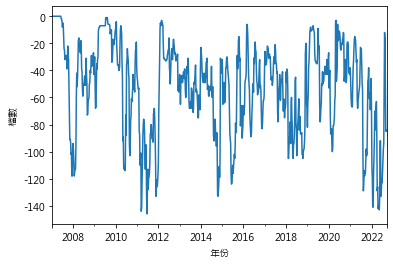

In [277]:
pzs1 = pzs.sort_index()
f1 = lambda x :float(x)
pzs2 = pzs1.applymap(f1)
pzs3 = pzs2.sum(axis=1)
pzs4 = pzs3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pzs4.mean())
print(pzs4.min())
print(pzs4.max())
pzs4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# 空單當週放空部位

In [278]:
空單放空部位 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1)]
空單放空 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1) & (pzs2.loc[前週日期]==0)]
空單回補 = pzs2.loc[當週日期][(pzs2.loc[當週日期]==0) & (pzs2.loc[前週日期]==-1)]
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補部位")
print(空單回補)
print("空單回補檔數" , len(空單回補))

空單放空標的
6147   -1.0
8183   -1.0
Name: 2022-09-23 00:00:00, dtype: float64
空單放空檔數 2
空單持有空單部位數目 84
空單回補部位
2368    0.0
2610    0.0
3526    0.0
Name: 2022-09-23 00:00:00, dtype: float64
空單回補檔數 3


In [288]:
空單放空部位

1533   -1.0
1611   -1.0
1727   -1.0
1762   -1.0
2049   -1.0
2303   -1.0
2337   -1.0
2340   -1.0
2344   -1.0
2354   -1.0
2374   -1.0
2379   -1.0
2401   -1.0
2449   -1.0
2603   -1.0
2637   -1.0
2641   -1.0
2906   -1.0
3028   -1.0
3034   -1.0
3035   -1.0
3037   -1.0
3042   -1.0
3059   -1.0
3105   -1.0
3141   -1.0
3169   -1.0
3217   -1.0
3221   -1.0
3317   -1.0
3527   -1.0
3624   -1.0
3645   -1.0
3675   -1.0
3687   -1.0
3706   -1.0
3708   -1.0
4721   -1.0
4736   -1.0
4739   -1.0
4755   -1.0
4919   -1.0
4927   -1.0
4952   -1.0
4961   -1.0
4966   -1.0
4976   -1.0
5269   -1.0
5285   -1.0
5289   -1.0
5299   -1.0
5609   -1.0
6104   -1.0
6120   -1.0
6138   -1.0
6147   -1.0
6180   -1.0
6182   -1.0
6191   -1.0
6217   -1.0
6237   -1.0
6257   -1.0
6274   -1.0
6278   -1.0
6282   -1.0
6411   -1.0
6435   -1.0
6488   -1.0
6491   -1.0
6679   -1.0
6732   -1.0
6781   -1.0
8016   -1.0
8027   -1.0
8044   -1.0
8046   -1.0
8150   -1.0
8155   -1.0
8183   -1.0
8215   -1.0
8358   -1.0
8440   -1.0
8464   -1.0
8924

# 空單歷年損益

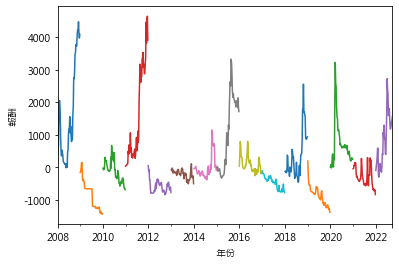

In [280]:

yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrts = trrs.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtsfig = trrts.plot()
trrtsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('空單歷年損益.png')

# 台積電策略

,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,...,MAXNS,MINN2330,MINNS,2330MA,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR
日期,,,,,,,,,,,,,,,,,,,,,
2022-07-22,495.5,505.0,486.5,503.0,73948506,0.42,164.319794,500.12,0.56,525.80,...,489.68,450.90,450.90,526.7595,531.0285,526.7595,433.0,0,0.0,0.000000
2022-07-29,500.0,510.0,491.0,509.0,60449457,0.40,166.494400,506.08,0.57,525.31,...,500.12,464.32,450.90,523.7730,526.7595,523.7730,433.0,0,0.0,0.000000
2022-08-05,506.0,516.0,488.5,516.0,79612324,0.38,169.247604,513.04,0.59,524.78,...,506.08,489.68,464.32,520.6975,523.7730,520.6975,433.0,0,0.0,0.000000
2022-08-12,510.0,518.0,499.5,517.0,57766953,0.38,169.583405,514.04,0.59,524.61,...,513.04,500.12,489.68,516.8315,520.6975,516.8315,449.5,0,0.0,0.000000
2022-08-19,520.0,527.0,517.0,519.0,54978043,0.37,169.916199,516.03,0.61,524.58,...,514.04,506.08,500.12,513.5100,516.8315,513.5100,486.5,1,0.0,0.000000
2022-08-26,511.0,515.0,502.0,512.0,42004744,0.37,167.669403,509.07,0.60,524.41,...,516.03,509.07,506.08,510.9280,513.5100,510.9280,488.5,1,1.0,-1.348759
2022-09-02,497.0,505.0,485.0,485.0,89657591,0.41,159.644501,482.22,0.61,524.07,...,516.03,482.22,509.07,507.2510,510.9280,507.2510,488.5,0,1.0,-5.274324
2022-09-09,485.0,491.5,472.0,475.0,53665551,0.42,157.117203,472.28,0.61,523.68,...,516.03,472.28,482.22,503.2745,507.2510,503.2745,485.0,0,0.0,-0.000000
2022-09-16,485.0,495.0,469.0,472.0,65945728,0.42,156.869293,472.00,0.61,520.48,...,516.03,472.00,472.28,500.2730,503.2745,500.2730,472.0,0,0.0,-0.000000


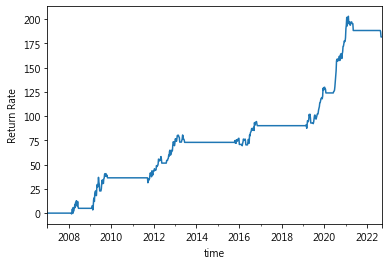

In [18]:
import talib
ERROR = []
trr2330 = pd.DataFrame()
pz2330 = pd.DataFrame()


    
DDW['2330']['MAXN2330'] = DDW['2330']["還原收盤價"].rolling(4).max()
DDW['2330']["MAXNS"] = DDW['2330']["MAXN2330"].shift(1)
DDW['2330']['MINN2330'] = DDW['2330']["還原收盤價"].rolling(4).min()
DDW['2330']["MINNS"] = DDW['2330']["MINN2330"].shift(1)
DDW['2330']["2330MA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["2330SMA"] = DDW['2330']["2330MA"].shift(1)
DDW['2330']["2330LMA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["DR"] = ((DDW['2330']["還原收盤價"] - DDW['2330']["還原收盤價"].shift(1))/DDW['2330']["還原收盤價"].shift(1))*100
DDW['TWA00']['4SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=4, matype=0)
DDW['TWA00']['20SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=20, matype=0)
DDW['2330']['出場價'] = DDW['2330']["最低價"].rolling(4).min().shift(1)
BS2330 = 0
BUY2330 =[]
for z in range(len(DDW['2330'])):

    if  DDW['2330']["還原收盤價"].iloc[z]  >  DDW['2330']["2330MA"].iloc[z] and DDW['2330']['收盤價'].iloc[z] > DDW['2330']['最高價'].rolling(2).max().shift(1).iloc[z] \
    and   DDW['TWA00']['4SHMA'].iloc[z] < 0.3 :
         BS2330 = 1

    elif  DDW['2330']["收盤價"].iloc[z] < DDW['2330']["出場價"].iloc[z]   :
        BS2330 = 0
        
    
        BS2330 = 0
        #buy.append("0")
    BUY2330.append(BS2330)
DDW['2330']["BUY2330"] = BUY2330
DDW['2330']["BUY2330S"] = DDW['2330']["BUY2330"].shift(1)
pz2330 = DDW['2330']["BUY2330S"]  
pz2330.name = '2330'
pzz2330 = DDW['2330']["BUY2330"]
pzz2330.name = '2330'
DDW['2330']["2330RR"] = DDW['2330']["DR"] * DDW['2330']["BUY2330S"].dropna().astype(int)
PTS2330 = DDW['2330']["2330RR"]
PTS2330.name = '2330'
if len(trr2330) == 0:
    trr2330 = PTS2330
else:
    trr2330 = pd.merge(trr2330,PTS2330,left_on = trrs.index,right_on = PTS.index,how = 'outer')
    trr2330.set_index('key_0',inplace = True)

trr2330fig = trr2330.cumsum().plot()
trr2330fig = plt.gcf()
plt.xlabel("time")
plt.ylabel("Return Rate")
trr2330fig.savefig('2330')
DDW['2330'].tail(10)

# 全市場夏普處理與合併

In [19]:
# 日期處理及設定reblance間隔

#設定rebalance頻率及sharpe觀察日數
rebalance = 52

#設定納入股票檔數
count = 10
fee = 2
#主程式
shar = pd.DataFrame()

#計算個股Sharpe ratio
for i in tqdm(DDW.keys()):
    change = DDW[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    DDW[str(i)]['rolling_ret'] = change.rolling(rebalance).mean()
    DDW[str(i)]['rolling_std'] = change.rolling(rebalance).std()
    DDW[str(i)]['sharpe105'] = DDW[str(i)]['rolling_ret'] / DDW[str(i)]['rolling_std']
    APT = DDW[str(i)]["sharpe105"]
    APT.name = str(i)

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)
        shar.index.name = '日期'
shar1 = shar.quantile(0.99,axis= 1)
shar2 = pd.DataFrame(shar1.sort_index()).rename(columns = {0.99:'sharp1'})
for key in tqdm(DDW.keys()):
    DDW[key] =  DDW[key].merge(shar2,left_index=True,right_index = True,how='left')
DDW['2330'].tail(1)

100%|██████████| 1776/1776 [00:01<00:00, 1212.75it/s]


,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,...,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR,rolling_ret,rolling_std,sharpe105,sharp1
日期,,,,,,,,,,,,,,,,,,,,,
2022-09-23,472.0,473.0,466.5,467.0,9713676,0.42,155.350906,467.0,0.61,520.26,...,500.273,497.516,469.0,0,0.0,-0.0,-0.003949,0.028451,-0.138787,0.307112


# 去除多欄(資料多_X才處理)

In [20]:
#for key in tqdm(DDW.keys()):
    #DDW[key] = DDW[key].drop(columns = ['sharp1_x','sharp1_y'])

# M夏普策略

100%|██████████| 1100/1100 [05:03<00:00,  3.63it/s]


<AxesSubplot:xlabel='key_0'>

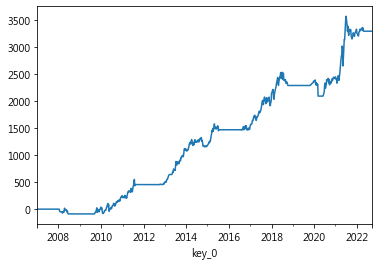

In [21]:
import talib
ERROR = []
trrmsharpe = pd.DataFrame()
pzmsp = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    BQT = 0
    BUYQT =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['sharpe105'].iloc[z] > DDW[str(x)]['sharp1'].iloc[z]  and DDW[str(x)]['成交金額(千)'].iloc[z] > 30000 and DDW[str(x)]['sharpe105'].iloc[z] > 0 \
        and DDW[str(x)]['資使用率'].iloc[z] < 30 and DDW[str(x)]['大盤夏普'].iloc[z] > 0.4 :
            BQT = 1

        elif   DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(1).rolling(4).min().iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z] < 0:
            BQT = 0
        
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        BUYQT.append(BQT)
    DDW[str(x)]["BUYQT"] = BUYQT
    DDW[str(x)]["BUYQTS"] = DDW[str(x)]["BUYQT"].shift(1)
    tqt = DDW[str(x)]["BUYQTS"]  
    tqt.name = str(x)
    pqt = DDW[str(x)]["BUYQT"]
    pqt.name = str(x)
    DDW[str(x)]["QTRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["BUYQTS"].dropna().astype(int)
    PQT = DDW[str(x)]["QTRR"]
    PQT.name = str(x)    
    if len(trrmsharpe) == 0:
        trrmsharpe = PQT
    else:
        trrmsharpe = pd.merge(trrmsharpe,PQT,left_on = trrmsharpe.index,right_on = PQT.index,how = 'outer')
        trrmsharpe.set_index('key_0',inplace = True)
    if len(pzmsp) == 0:
        pzmsp = pqt
    else:
        pzmsp = pd.merge(pzmsp,pqt,left_on = pzmsp.index,right_on = pqt.index,how = 'outer')
        pzmsp.set_index('key_0',inplace = True)

tqt1 = trrmsharpe.sort_index().sum(axis = 1).cumsum()
tqt1.plot()

# 整理夏普買賣訊01值

8.12667478684531
0.0
28.0


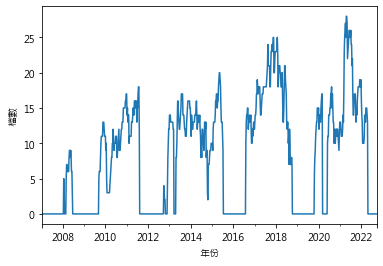

In [61]:
夏普1 = pzmsp.sort_index()
f2 = lambda x :float(x)
夏普2 = 夏普1.applymap(f2)
夏普3 = 夏普2.sum(axis=1)
夏普部位 =夏普3.groupby(pd.Grouper(freq='1W')).tail(1)
print(夏普部位.mean())
print(夏普部位.min())
print(夏普部位.max())
夏普部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# M夏普當週買進部位

In [62]:
M夏普持有部位 = 夏普2.loc[當週日期][夏普2.loc[當週日期] ==1]
M夏普買進 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==1) & (夏普2.loc[前週日期] ==0)]
M夏普賣出 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==0) & (夏普2.loc[前週日期] ==1)]
print("M夏普買進標的")
print(M夏普買進)
print("M夏普買進檔數" , len(M夏普買進))
print("M夏普持有部位數目" , len(M夏普持有部位))
print("M夏普賣出部位")
print(M夏普賣出)
print("M夏普賣出檔數" , len(M夏普賣出))

M夏普買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
M夏普買進檔數 0
M夏普持有部位數目 0
M夏普賣出部位
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
M夏普賣出檔數 0


# 夏普歷年損益

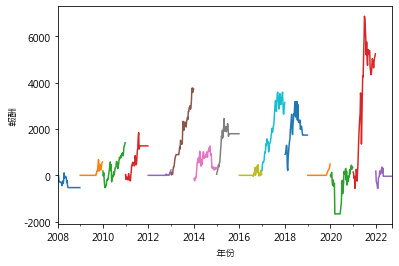

In [24]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrtms = trrmsharpe.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtmsfig = (trrtms*6).plot()
trrtmsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtmsfig.savefig('M夏普歷年損益.png')

# 量能突破策略

100%|██████████| 1100/1100 [05:36<00:00,  3.27it/s]


Text(0, 0.5, 'Profit')

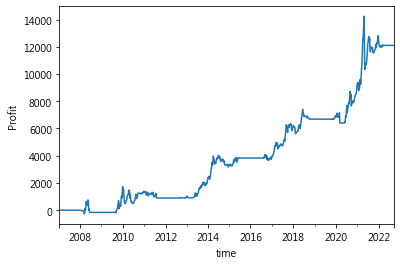

In [25]:
import talib
ERROR = []
trrv = pd.DataFrame()
pvz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['SMAX52'] = DDW[str(x)]["還原收盤價"].rolling(4).max()
    DDW[str(x)]["SMAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    VBS = 0
    VBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["成交金額(千)"].iloc[z]  > (DDW[str(x)]["成交金額(千)"].shift(1)*1.5).iloc[z] and DDW[str(x)]["成交金額(千)"].iloc[z] > 100000 \
        and DDW[str(x)]["收盤價"].iloc[z]  > (DDW[str(x)]["最高價"].shift(2)*1.1).iloc[z] and DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]["SMAX52S"].iloc[z] \
        and DDW[str(x)]['大盤夏普'].iloc[z] > 0.3:
        
            VBS = 1

        elif  DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(2).iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z]  < 0.3 :
            VBS = 0
            #buy.append("0")
        VBUY.append(VBS)
    DDW[str(x)]["VBUY"] = VBUY
    DDW[str(x)]["VBUYS"] = DDW[str(x)]["VBUY"].shift(1)
    pzb = DDW[str(x)]["VBUYS"]  
    pzb.name = str(x)
    pvzbs = DDW[str(x)]["VBUY"]
    pvzbs.name = str(x)
    DDW[str(x)]["RR"] = DDW[str(x)]["DR"] * DDW[str(x)]["VBUYS"].dropna().astype(int)
    PVT = DDW[str(x)]["RR"]
    PVT.name = str(x)
    if len(trr) == 0:
        trrv = PVT
    else:
        trrv = pd.merge(trrv,PVT,left_on = trrv.index,right_on = PVT.index,how = 'outer')
        trrv.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pvz = pvzbs
    else:
        pvz = pd.merge(pvz,pvzbs,left_on = pvz.index,right_on = pvzbs.index,how = 'outer')
        pvz.set_index('key_0',inplace = True)

trrv1 =trrv.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")

# 整理量能買賣訊01值

34.33252131546894
0.0
263.0


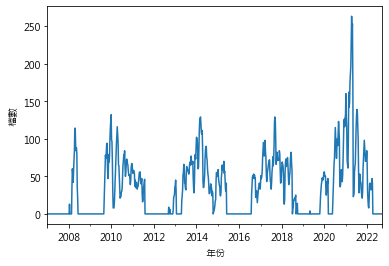

In [26]:
pvz1 = pvz.sort_index()
f4 = lambda x :float(x)
pvz2 = pvz1.applymap(f4)
pvz3 = pvz2.sum(axis=1)
pvz4 = pvz3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pvz4.mean())
print(pvz4.min())
print(pvz4.max())
pvz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# <font color="red">量能當週買進部位</font>

In [27]:
#當週日期 = '2022-08-26'
#前週日期 = '2022-08-19'

量能持有部位 = pvz2.loc[當週日期][pvz2.loc[當週日期] ==1]
量能買進 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==1) & (pvz2.loc[前週日期] ==0)]
量能賣出 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==0) & (pvz2.loc[前週日期] ==1)]
print("量能買進標的")
print(量能買進)
print("量能買進檔數" , len(量能買進))
print("量能持有部位數目" , len(量能持有部位))
print("量能賣出部位")
print(量能賣出)
print("量能賣出檔數" , len(量能賣出))

量能買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能買進檔數 0
量能持有部位數目 0
量能賣出部位
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能賣出檔數 0


# 低接策略

100%|██████████| 1100/1100 [05:58<00:00,  3.07it/s]


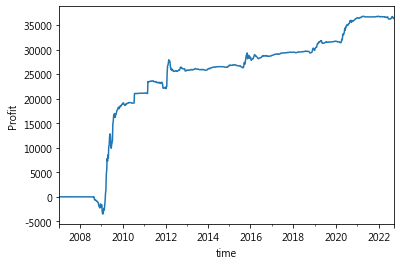

In [28]:
import talib
ERROR = []
trrkd = pd.DataFrame()
pzkd1 = pd.DataFrame()

for x in tqdm(SKTCRI):
    DDW[str(x)]["K"],DDW[str(x)]["D"] = talib.STOCH(DDW[str(x)]['最高價'], 
                              DDW[str(x)]['最低價'], 
                              DDW[str(x)]['收盤價'], 
                              fastk_period=52,
                              slowk_period=10,
                              slowk_matype=1,
                              slowd_period=10,
                              slowd_matype=1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    KDBS = 0
    KDBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["K"].iloc[z] > DDW[str(x)]["D"].iloc[z] and DDW[str(x)]["K"].shift(1).iloc[z] < DDW[str(x)]["D"].shift(1).iloc[z] \
        and DDW[str(x)]['成交金額(千)'].iloc[z] < 500000  \
        and DDW[str(x)]['D'].iloc[z] < 20 and DDW[str(x)]['還原收盤價'].iloc[z] < (DDW[str(x)]['MAX52S']*0.7).iloc[z] :
        
            KDBS = 1

        elif  DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].rolling(4).min().shift(1).iloc[z] :
            KDBS = 0
            #buy.append("0")
        KDBUY.append(KDBS)
    DDW[str(x)]["KDBUY"] = KDBUY
    DDW[str(x)]["KDBUYS"] = DDW[str(x)]["KDBUY"].shift(1)
    pzkd = DDW[str(x)]["KDBUYS"]  
    pzkd.name = str(x)
    pzkds = DDW[str(x)]["KDBUY"]
    pzkds.name = str(x)
    DDW[str(x)]["KDRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KDBUYS"].dropna().astype(int)
    PVKD= DDW[str(x)]["KDRR"]
    PVKD.name = str(x)
    if len(trrkd) == 0:
        trrkd = PVKD
    else:
        trrkd = pd.merge(trrkd,PVKD,left_on = trrkd.index,right_on = PVKD.index,how = 'outer')
        trrkd.set_index('key_0',inplace = True)
    if len(pzkd) == 0:
        pzkd1 = pzkds
    else:
        pzkd1 = pd.merge(pzkd1,pzkds,left_on = pzkd1.index,right_on = pzkds.index,how = 'outer')
        pzkd1.set_index('key_0',inplace = True)

trrkd1 =trrkd.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")
plt.savefig('低接損益')

# 整理低接買賣訊01值

47.09866017052375
0.0
343.0


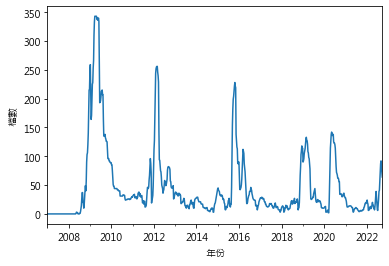

In [29]:
KD1 = pzkd1.sort_index()
f6 = lambda x :float(x)
KD2 = KD1.applymap(f6)
KD3 = KD2.sum(axis=1)
KD部位 =KD3.groupby(pd.Grouper(freq='1W')).tail(1)
print(KD部位.mean())
print(KD部位.min())
print(KD部位.max())
KD部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('低接部位變化表.png')

# 低接當週買進部位

In [63]:

低接持有部位 = KD2.loc[當週日期][KD2.loc[當週日期] ==1]
低接買進 = KD2.loc[當週日期][(KD2.loc[當週日期] ==1) & (KD2.loc[前週日期] ==0)]
低接賣出 = KD2.loc[當週日期][(KD2.loc[當週日期] ==0) & (KD2.loc[前週日期] ==1)]
print("低接買進標的")
print(低接買進)
print("低接買進檔數" , len(低接買進))
print("低接持有部位數目" , len(低接持有部位))
print("低接賣出部位")
print(低接賣出)
print("低接賣出檔數" , len(低接賣出))

低接買進標的
1308    1.0
Name: 2022-09-23 00:00:00, dtype: float64
低接買進檔數 1
低接持有部位數目 64
低接賣出部位
1325    0.0
3031    0.0
3306    0.0
3437    0.0
3563    0.0
3663    0.0
4735    0.0
4989    0.0
6274    0.0
8086    0.0
Name: 2022-09-23 00:00:00, dtype: float64
低接賣出檔數 10


# 融資爆發策略


100%|██████████| 1100/1100 [03:46<00:00,  4.85it/s]


Text(0, 0.5, 'Profit')

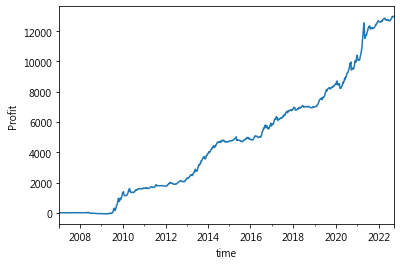

In [93]:
import talib
ERROR = []
trrmm = pd.DataFrame()
pzmm = pd.DataFrame()
pzmm1 = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    MMBS = 0
    MMBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['融資維持率(%)'].iloc[z] > 170 and DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 170  \
        and  DDW[str(x)]['成交金額(千)'].iloc[z] < 250000 and DDW[str(x)]['K'].iloc[z] > 50 and DDW[str(x)]['資使用率'].iloc[z] < 15 and  DDW[str(x)]['成交金額(千)'].iloc[z] > 10000 :
        
            MMBS = 1

        elif    (DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 160) or \
         (DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].shift(1).iloc[z] and DDW[str(x)]['還原收盤價'].iloc[z] < DDW[str(x)]['4MA'].iloc[z] ):
            MMBS = 0
            #buy.append("0")
        MMBUY.append(MMBS)
    DDW[str(x)]["MMBUY"] = MMBUY
    DDW[str(x)]["MMBUYS"] = DDW[str(x)]["MMBUY"].shift(1)
    pzmm = DDW[str(x)]["MMBUYS"]  
    pzmm.name = str(x)
    pzmms = DDW[str(x)]["MMBUY"]
    pzmms.name = str(x)
    DDW[str(x)]["MMRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["MMBUYS"].dropna().astype(int)
    PVMM= DDW[str(x)]["MMRR"]
    PVMM.name = str(x)
    if len(trrmm) == 0:
        trrmm = PVMM
    else:
        trrmm = pd.merge(trrmm,PVMM,left_on = trrmm.index,right_on = PVMM.index,how = 'outer')
        trrmm.set_index('key_0',inplace = True)
    if len(pzmm) == 0:
        pzmm1 = pzmms
    else:
        pzmm1 = pd.merge(pzmm1,pzmms,left_on = pzmm1.index,right_on = pzmms.index,how = 'outer')
        pzmm1.set_index('key_0',inplace = True)

trrmm1 =trrmm.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理融資爆發買賣訊01值

25.442143727161998
0.0
134.0


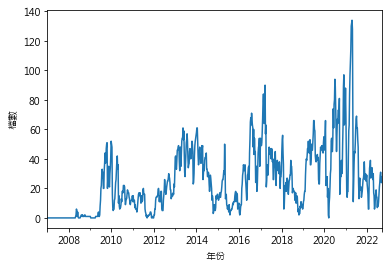

In [94]:
MM1 = pzmm1.sort_index()
f12 = lambda x :float(x)
MM2 = MM1.applymap(f12)
MM3 = MM2.sum(axis=1)
MM部位 =MM3.groupby(pd.Grouper(freq='1W')).tail(1)
print(MM部位.mean())
print(MM部位.min())
print(MM部位.max())
MM部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# 融資爆發當週買進部位

In [95]:
MM持有部位 = MM2.loc[當週日期][(MM2.loc[當週日期]==1)]
MM買進 = MM2.loc[當週日期][(MM2.loc[當週日期]==1) & (MM2.loc[前週日期]==0)]
MM賣出 = MM2.loc[當週日期][(MM2.loc[當週日期]==0) & (MM2.loc[前週日期]==1)]
print("MM買進標的")
print(MM買進)
print("MM買進檔數" , len(MM買進))
print("MM持有部位數目" , len(MM持有部位))
print("MM賣出部位")
print(MM賣出)
print("MM賣出檔數" , len(MM賣出))

MM買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
MM買進檔數 0
MM持有部位數目 24
MM賣出部位
1720    0.0
2362    0.0
4566    0.0
6579    0.0
Name: 2022-09-23 00:00:00, dtype: float64
MM賣出檔數 4


# 外資策略

100%|██████████| 1100/1100 [03:40<00:00,  4.99it/s]


Text(0, 0.5, 'Profit')

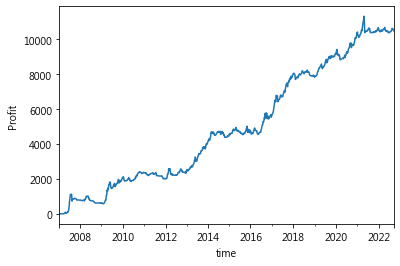

In [34]:
import talib
ERROR = []
trrtest = pd.DataFrame()
pztest = pd.DataFrame()
pztest1 = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    
    DDW[str(x)]["FF4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=10, matype=0)
    DDW[str(x)]["FF4MAS"] = DDW[str(x)]["FF4MA"].shift(1)
    DDW[str(x)]['FFMAX'] = DDW[str(x)]["還原收盤價"].rolling(10).max()
    DDW[str(x)]["FFMAXS"] = DDW[str(x)]["FFMAX"].shift(1)
    DDW[str(x)]["FFMINS"] = DDW[str(x)]["最低價"].rolling(10).min().shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    #DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    TESTBS = 0
    TESTBUY =[]
    for z in range(len(DDW[str(x)])):

        if  DDW[str(x)]['外資持股比率(%)'].iloc[z] > DDW[str(x)]['外資持股比率(%)'].shift(1).iloc[z] and DDW[str(x)]['外資持股比率(%)'].iloc[z] >10 \
        and  DDW[str(x)]['成交金額(千)'].iloc[z] < 700000 and DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]['FFMAXS'].iloc[z] and  DDW[str(x)]['成交金額(千)'].iloc[z] > 50000 \
        and DDW[str(x)]['外資持股比率(%)'].iloc[z] > DDW[str(x)]['外資持股比率(%)'].shift(10).iloc[z] :
            TESTBS = 1

        elif DDW[str(x)]['還原收盤價'].iloc[z] < (DDW[str(x)]['FF4MA'].iloc[z]) or DDW[str(x)]['收盤價'].iloc[z] < (DDW[str(x)]['FFMINS'].iloc[z]) \
        or (DDW[str(x)]['外資持股比率(%)'].iloc[z] < DDW[str(x)]['外資持股比率(%)'].shift(5).iloc[z] and DDW[str(x)]['還原收盤價'].iloc[z] < DDW[str(x)]['還原收盤價'].shift(3).iloc[z]):
            TESTBS = 0
            #buy.append("0")
        TESTBUY.append(TESTBS)
    DDW[str(x)]["TESTBUY"] = TESTBUY
    DDW[str(x)]["TESTBUYS"] = DDW[str(x)]["TESTBUY"].shift(1)
    pztests = DDW[str(x)]["TESTBUYS"]  
    pztests.name = str(x)
    pztest = DDW[str(x)]["TESTBUY"]
    pztest.name = str(x)
    DDW[str(x)]["TESTRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["TESTBUYS"].dropna().astype(int)
    PVTEST= DDW[str(x)]["TESTRR"]
    PVTEST.name = str(x)
    if len(trrtest) == 0:
        trrtest = PVTEST
    else:
        trrtest = pd.merge(trrtest,PVTEST,left_on = trrtest.index,right_on = PVTEST.index,how = 'outer')
        trrtest.set_index('key_0',inplace = True)
    if len(pztest) == 0:
        pztest1 = pztest
    else:
        pztest1 = pd.merge(pztest1,pztest,left_on = pztest1.index,right_on = pztest.index,how = 'outer')
        pztest1.set_index('key_0',inplace = True)

trrtest1 =trrtest.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理外資買賣訊01值

34.40925700365408
0.0
131.0


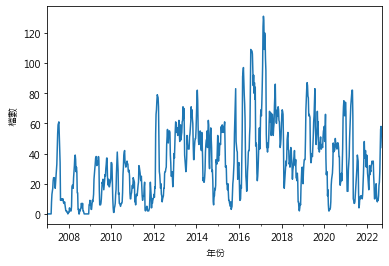

In [149]:
外資1 = pztest1.sort_index()
fsit = lambda x :float(x)
外資2 = 外資1.applymap(fsit)
外資3 = 外資2.sum(axis=1)
外資4 = 外資3.groupby(pd.Grouper(freq='1W')).tail(1)
print(外資4.mean())
print(外資4.min())
print(外資4.max())
外資4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('外資部位變化表.png')

# 外資當週買進部位

In [65]:
外資持有部位 = 外資2.loc[當週日期][外資2.loc[當週日期] ==1]
外資買進 = 外資2.loc[當週日期][(外資2.loc[當週日期] ==1) & (外資2.loc[前週日期] ==0)]
外資賣出 = 外資2.loc[當週日期][(外資2.loc[當週日期] ==0) & (外資2.loc[前週日期] ==1)]
print("外資買進標的")
print(外資買進)
print("外資買進檔數" , len(外資買進))
print("外資持有部位數目" , len(外資持有部位))
print("外資賣出部位")
print(外資賣出)
print("外資賣出檔數" , len(外資賣出))

外資買進標的
2206    1.0
Name: 2022-09-23 00:00:00, dtype: float64
外資買進檔數 1
外資持有部位數目 44
外資賣出部位
1582    0.0
1712    0.0
1907    0.0
2355    0.0
2421    0.0
2428    0.0
3022    0.0
3023    0.0
3531    0.0
4906    0.0
6121    0.0
8105    0.0
Name: 2022-09-23 00:00:00, dtype: float64
外資賣出檔數 12


Text(0, 0.5, '報酬')

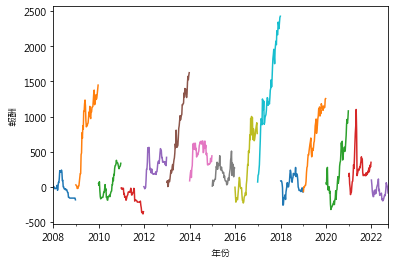

In [37]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrtestw = trrtest.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtestfig = (trrtestw).plot()


plt.xlabel("年份")
plt.ylabel("報酬")


In [38]:
print("外資持有部位數目")
print(list(外資持有部位.index))

外資持有部位數目
['1104', '1526', '1537', '1582', '1599', '1701', '1707', '1712', '1907', '2066', '2104', '2355', '2362', '2392', '2421', '2428', '2439', '2495', '2504', '2536', '2548', '2707', '2754', '2903', '3022', '3023', '3376', '3531', '3611', '3703', '4167', '4532', '4536', '4557', '4763', '4906', '4977', '5015', '5225', '5284', '6121', '6139', '6153', '6451', '6605', '6612', '6670', '6768', '8105', '8163', '8938', '9904', '9907', '9924', '9939']


<AxesSubplot:xlabel='日期'>

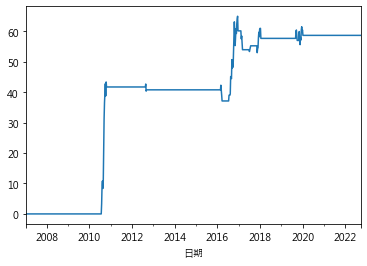

In [39]:
DDW['1304']['TESTRR'].cumsum().plot()

# 所有策略部位變化與配置

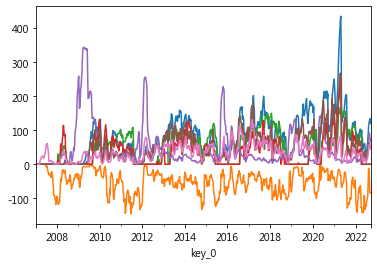

In [281]:
pz4.plot()#關鍵點
pzs4.plot()#放空
(夏普部位*6).plot()#強勢夏普
pvz4.plot()#量能
KD部位.plot()#低接
(MM部位*2).plot()#融資
外資4.plot()
plt.savefig('所有策略檔數')


<AxesSubplot:xlabel='key_0'>

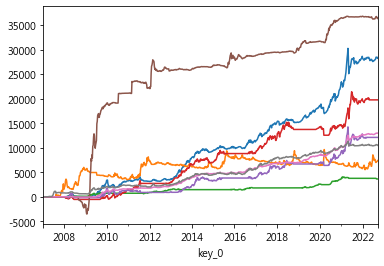

In [282]:
trr.sort_index().sum(axis = 1).cumsum().plot()
trrs.sort_index().sum(axis = 1).cumsum().plot()
(trr2330*20).sort_index().cumsum().plot()
(trrmsharpe.sort_index().sum(axis = 1).cumsum()*6).plot()
trrv.sort_index().sum(axis = 1).cumsum().plot()
trrkd.sort_index().sum(axis = 1).cumsum().plot()
(trrmm.sort_index().sum(axis = 1).cumsum()).plot()
trrtest.sort_index().sum(axis = 1).cumsum().plot()

# 淨部位變化

多空總部位 168.0


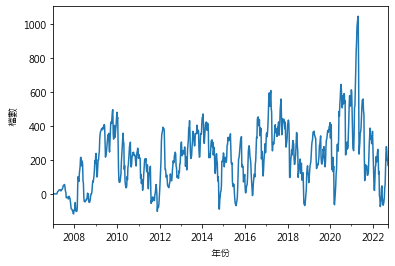

In [283]:
總部位變化 =  pz4 + pzs4 + (夏普部位*6) +pvz4 +KD部位  +MM部位+ 外資4
總部位變化.plot()
print('多空總部位',總部位變化[當週日期])
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('總部位變化水位')

In [284]:
總部位變化.tail(3)

key_0
2022-09-09    195.0
2022-09-16    205.0
2022-09-23    168.0
dtype: float64

# 混合策略損益

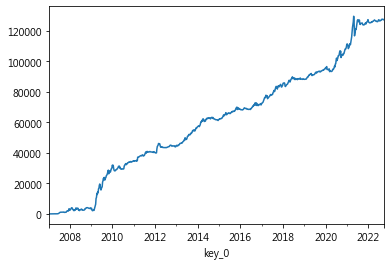

In [285]:
所有策略加總 = (tqt1*6) + trrsp + (trrv.sort_index().sum(axis = 1).cumsum()) +(trr2330*20) + (trr.sort_index().sum(axis = 1).cumsum()) + (trrkd.sort_index().sum(axis = 1).cumsum()) \
+ trrtest.sort_index().sum(axis = 1).cumsum() +(trrmm.sort_index().sum(axis = 1).cumsum())
所有策略加總.plot()
plt.savefig("所有策略加總")

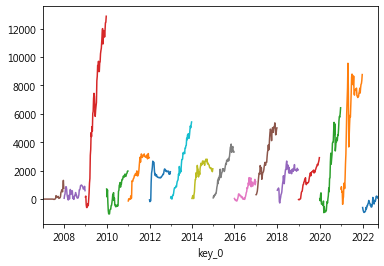

In [286]:
分年加總 = (trr.sort_index().sum(axis = 1)) + (trrs.sort_index().sum(axis = 1)) + (trrmsharpe.sort_index().sum(axis = 1))*6 + \
(trrv.sort_index().sum(axis = 1)) +(trrkd.sort_index().sum(axis = 1)) +(trrmm.sort_index().sum(axis = 1)) 
(分年加總['2022']*0.5).cumsum().plot()
(分年加總['2021']*0.5).cumsum().plot()
(分年加總['2020']*0.5).cumsum().plot()
(分年加總['2019']*0.5).cumsum().plot()
(分年加總['2018']*0.5).cumsum().plot()
(分年加總['2017']*0.5).cumsum().plot()
(分年加總['2016']*0.5).cumsum().plot()
(分年加總['2015']*0.5).cumsum().plot()
(分年加總['2014']*0.5).cumsum().plot()
(分年加總['2013']*0.5).cumsum().plot()
(分年加總['2012']*0.5).cumsum().plot()
(分年加總['2011']*0.5).cumsum().plot()
(分年加總['2010']*0.5).cumsum().plot()
(分年加總['2009']*0.5).cumsum().plot()
(分年加總['2008']*0.5).cumsum().plot()
(分年加總['2007']*0.5).cumsum().plot()

plt.savefig('分年損益')


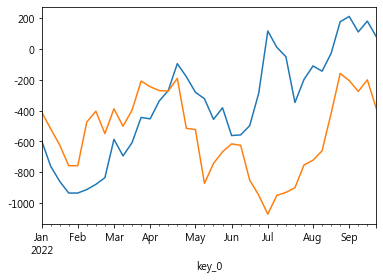

In [287]:
(分年加總['2022']*0.5).cumsum().plot()
(trr['2022'].sort_index().sum(axis = 1).cumsum()).plot()
plt.savefig("前後比較")

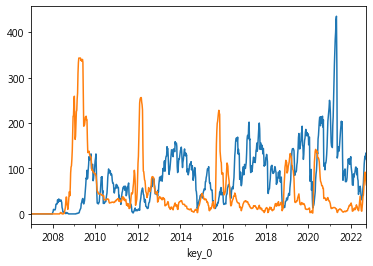

In [209]:
pz4.plot()#關鍵點
#pzs4.plot()
#(夏普部位*6).plot()
#pvz4.plot()
KD部位.plot()
#(MM部位*2).plot()
plt.savefig('檔數交會')

# 當週彙總整理

In [212]:
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出標的")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))
print("M夏普買進標的")
print(M夏普買進)
print("M夏普買進檔數" , len(M夏普買進))
print("M夏普持有部位數目" , len(M夏普持有部位))
print("M夏普賣出標的")
print(M夏普賣出)
print("M夏普賣出檔數" , len(M夏普賣出))
print("量能買進標的")
print(量能買進)
print("量能買進檔數" , len(量能買進))
print("量能持有部位數目" , len(量能持有部位))
print("量能賣出標的")
print(量能賣出)
print("量能賣出檔數" , len(量能賣出))
print("低接買進標的")
print(低接買進)
print("低接買進檔數" , len(低接買進))
print("低接持有部位數目" , len(低接持有部位))
print("低接賣出標的")
print(低接賣出)
print("低接賣出檔數" , len(低接賣出))
print("融資爆發買進標的")
print(MM買進)
print("融資爆發買進檔數" , len(MM買進))
print("融資爆發持有部位數目" , len(MM持有部位))
print("融資爆發賣出標的")
print(MM賣出)
print("融資爆發賣出檔數" , len(MM賣出))
print("外資買進標的")
print(外資買進)
print("外資買進檔數" , len(外資買進))
print("外資持有部位數目" , len(外資持有部位))
print("外資賣出標的")
print(外資賣出)
print("外資賣出檔數" , len(外資賣出))
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補標的")
print(空單回補)


關鍵點買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
關鍵點買進檔數 0
關鍵點持有部位數目 120
關鍵點賣出標的
1444    0.0
1712    0.0
1720    0.0
1733    0.0
2065    0.0
3209    0.0
3531    0.0
4543    0.0
4557    0.0
4906    0.0
5278    0.0
6469    0.0
8234    0.0
8420    0.0
Name: 2022-09-23 00:00:00, dtype: float64
關鍵點賣出檔數 14
M夏普買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
M夏普買進檔數 0
M夏普持有部位數目 0
M夏普賣出標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
M夏普賣出檔數 0
量能買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能買進檔數 0
量能持有部位數目 0
量能賣出標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能賣出檔數 0
低接買進標的
1308    1.0
Name: 2022-09-23 00:00:00, dtype: float64
低接買進檔數 1
低接持有部位數目 64
低接賣出標的
1325    0.0
3031    0.0
3306    0.0
3437    0.0
3563    0.0
3663    0.0
4735    0.0
4989    0.0
6274    0.0
8086    0.0
Name: 2022-09-23 00:00:00, dtype: float64
低接賣出檔數 10
融資爆發買進標的
Series([], Name: 2022-09-23 00:00:00, dtype: float64)
融資爆發買進檔數 0
融資爆發持有部位數目 24
融資爆發賣出標的
1720    0.0
2362    

In [213]:
pd.set_option('display.max_rows',None)
print('關鍵點持有部位')
print(list(關鍵點持有部位.index))
print('M夏普持有部位')
print(list(M夏普持有部位.index))
print('量能持有部位')
print(list(量能持有部位.index))
print('低接持有部位')
print(list(低接持有部位.index))
print('融資爆發持有部位')
print(list(MM持有部位.index))
print('空單持有部位')
print(list(空單放空部位.index))
print('外資持有部位')
print(list(外資持有部位.index))

關鍵點持有部位
['1104', '1215', '1218', '1232', '1319', '1321', '1336', '1339', '1342', '1402', '1410', '1451', '1503', '1513', '1537', '1582', '1736', '1752', '1784', '1786', '2066', '2105', '2206', '2211', '2228', '2301', '2362', '2402', '2467', '2474', '2483', '2488', '2534', '2536', '2539', '2548', '2707', '2729', '2752', '2754', '3002', '3022', '3090', '3293', '3380', '3454', '3564', '3596', '3617', '3703', '4104', '4105', '4107', '4111', '4119', '4129', '4155', '4163', '4438', '4532', '4536', '4566', '4763', '4766', '4908', '4915', '4977', '5015', '5225', '5284', '5288', '5353', '5403', '5426', '5434', '5534', '5536', '6115', '6146', '6153', '6176', '6183', '6221', '6227', '6245', '6263', '6279', '6285', '6432', '6472', '6570', '6605', '6613', '6666', '6690', '6727', '6768', '6803', '8049', '8050', '8069', '8072', '8083', '8109', '8131', '8279', '8349', '8401', '8403', '8432', '8478', '8916', '8938', '9907', '9924', '9925', '9933', '9937', '9939', '9942']
M夏普持有部位
[]
量能持有部位
[]
低接持有部位
['1

# 育儀每週需求資料

In [78]:
import math
import datetime
育儀檔DF = pd.DataFrame()
育儀檔DF['空單賣出標的'] = list(空單放空.index)
lsws=[]
張數=[]
for i in range(len(育儀檔DF)):
    lsws.append(DDW[育儀檔DF.iloc[i,0]].tail(1).iloc[0,3])
育儀檔DF['空單賣出收盤價'] = lsws
for l in range(len(育儀檔DF)):
    張數 = 500000/(育儀檔DF['空單賣出收盤價']*1000)
floormethod = lambda x :math.floor(x)

育儀檔DF['需求張數'] = 張數.apply(floormethod)

育儀檔DF
育儀檔DF.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\借券\每週空單需求'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')

# 每週買賣總表

In [79]:
每週買DF = pd.DataFrame()
每週買DF = pd.concat([每週買DF,pd.DataFrame(關鍵點買進.index,columns = ['關鍵點買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(關鍵點賣出.index,columns = ['關鍵點賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(M夏普買進.index,columns = ['M夏普買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(M夏普賣出.index,columns = ['M夏普賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(量能買進.index,columns = ['量能買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(量能賣出.index,columns = ['量能賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(低接買進.index,columns = ['低接買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(低接賣出.index,columns = ['低接賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(MM買進.index,columns = ['融資買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(MM賣出.index,columns = ['融資賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(外資買進.index,columns = ['外資買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(外資賣出.index,columns = ['外資賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(空單放空.index,columns = ['空單放空'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(空單回補.index,columns = ['空單回補'])],axis=1)
每週買DF

,關鍵點買進,M夏普買進,量能買進,低接買進,融資買進,外資買進,空單放空
0,NaN,NaN,NaN,1308,NaN,2206,6147


In [80]:
import datetime

每週買DF.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\買進\每週買進總表'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')

In [81]:
每週賣DF = pd.DataFrame()
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(關鍵點買進.index,columns = ['關鍵點買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(關鍵點賣出.index,columns = ['關鍵點賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(M夏普買進.index,columns = ['M夏普買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(M夏普賣出.index,columns = ['M夏普賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(量能買進.index,columns = ['量能買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(量能賣出.index,columns = ['量能賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(低接買進.index,columns = ['低接買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(低接賣出.index,columns = ['低接賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(MM買進.index,columns = ['融資買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(MM賣出.index,columns = ['融資賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(外資買進.index,columns = ['外資買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(外資賣出.index,columns = ['外資賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(空單放空.index,columns = ['空單放空'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(空單回補.index,columns = ['空單回補'])],axis=1)
每週賣DF


,關鍵點賣出,M夏普賣出,量能賣出,低接賣出,融資賣出,外資賣出,空單回補
0,1444,NaN,NaN,1325,1321,1582,3515
1,1712,NaN,NaN,3031,1339,1712,NaN
2,1720,NaN,NaN,3306,2362,1907,NaN
3,1733,NaN,NaN,3437,2467,2355,NaN
4,2065,NaN,NaN,3563,2534,2421,NaN
5,3209,NaN,NaN,3663,3617,2428,NaN
6,3531,NaN,NaN,4735,4566,3022,NaN
7,4543,NaN,NaN,4989,9924,3023,NaN
8,4557,NaN,NaN,6274,NaN,3531,NaN
9,4906,NaN,NaN,8086,NaN,4906,NaN


In [82]:
每週賣DF.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\賣出\每週賣出總表'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')

In [289]:
DDW['3041']['SELL'].tail(30)

日期
2022-03-04    0
2022-03-11    0
2022-03-18    0
2022-03-25    0
2022-04-01    0
2022-04-08    0
2022-04-15    0
2022-04-22    0
2022-04-29    0
2022-05-06    0
2022-05-13    0
2022-05-20    0
2022-05-27    0
2022-06-03    0
2022-06-10    0
2022-06-17    0
2022-06-24    0
2022-07-01    0
2022-07-08    0
2022-07-15    0
2022-07-22    0
2022-07-29    0
2022-08-05    0
2022-08-12    0
2022-08-19    0
2022-08-26    0
2022-09-02    0
2022-09-09    0
2022-09-16    0
2022-09-23    0
Freq: W-FRI, Name: SELL, dtype: int64